In [1]:
# import modules
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import display
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import scipy

In [2]:
train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")

In [3]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [4]:
test.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


In [5]:
labels.head()

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [6]:
# ubjects, who had more than ~95 sequences, 
# were more likely to get target "1" and 
# subjects, who had less than ~25 sequences, w
# ere more likely to get target "0". 

def sub_imp(x):
    if x < 25:
        return 0
    elif x > 95:
        return 2
    else:
        return 1
    
def engineering(df):
    for sensor in sensors:
        # add lag feature and difference
        df[sensor + '_lag1'] = df.groupby('sequence')[sensor].shift(1)
        # df[sensor + '_lag10'] = df.groupby('sequence')[sensor].shift(10)
        # df[sensor + '_back_lag1'] = df.groupby('sequence')[sensor].shift(-1)
        df.fillna(0, inplace=True)
        # df[sensor + '_diff1'] = df[sensor] - df[sensor + '_lag1']   
        
    sub_stat = df[['sequence', 'subject']].drop_duplicates().groupby('subject').agg({'sequence': 'count'})\
    .rename(columns={'sequence': 'count'}).reset_index()
    df = df.merge(sub_stat, on='subject', how='left')
    df['sub_imp'] = df['count'].apply(lambda x: sub_imp(x))
    df.drop('count', axis=1, inplace=True)
    
    return df

In [7]:
sensors = [col for col in train.columns if 'sensor_' in col]
train = engineering(train)
test = engineering(test)

In [8]:
groups = train['sequence']
train = train.drop(['sequence', 'subject', 'step'], inplace=False, axis=1).values
test = test.drop(['sequence', 'subject', 'step'], inplace=False, axis=1).values
labels = labels['state']

In [9]:
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [10]:
# start
print(train.shape)
print(test.shape)

# reshape dataset as an input of LSTM model
train = train.reshape(int(len(train)/60), 60, train.shape[-1])
test = test.reshape(int(len(test)/60), 60, test.shape[-1])

print(f'train reshape: {train.shape}')
print(f'test reshape: {test.shape}')

(1558080, 27)
(733080, 27)
train reshape: (25968, 60, 27)
test reshape: (12218, 60, 27)


In [11]:
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import AUC

def BuildNN():
    # with tpu_strategy.scope():
    ip = Input(shape=(60, train.shape[-1]))
    x11 = Conv1D(train.shape[-1], 2, padding='same')(ip)
    x12 = Conv1D(train.shape[-1], 4, padding='same')(ip)
    x = Concatenate(axis=2)([x11, x12])
    
    y1 = LSTM(512, return_sequences=True)(x)
    y2 = LSTM(256, return_sequences=True)(y1)
    y3 = LSTM(128, return_sequences=True)(y2)
    y = Flatten()(y3)
    
    x21 = Dense(128, activation='swish')(y)
    x22 = Dropout(0.2)(x21)
    x23 = Dense(64, activation='swish')(x22)
    op = Dense(1, activation='sigmoid')(x23)

    model = Model(ip, op)
    print(model.summary())
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[keras.metrics.AUC()])
    return model

In [12]:
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [13]:
cv_score = 0
test_preds = []
kf = GroupKFold(n_splits=5)

for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(train, labels, groups.unique())):
    # split train and label into X, y train and valid set.
    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = labels.iloc[train_idx].values, labels.iloc[valid_idx].values
    
    # Run the model
    model = BuildNN()
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=256, 
              callbacks=[reduce_lr, early_stopping])
    
    # add roc_auc_score of each fold
    score = roc_auc_score(y_valid, model.predict(X_valid).squeeze())
    print(f"cv: {fold_idx + 1}, score: {score}")
    cv_score += score
    
    # append predictions
    test_preds.append(model.predict(test).squeeze())
    
print(cv_score/5)

2022-04-23 09:01:59.310995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 09:01:59.415498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 09:01:59.416616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 09:01:59.419096: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 27)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 60, 27)       1485        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 27)       2943        input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60, 54)       0           conv1d[0][0]                     
                                                                 conv1d_1[0][0]               

2022-04-23 09:02:03.787293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-04-23 09:02:09.655616: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


82/82 [==============================] - 19s 77ms/step - loss: 0.6135 - auc: 0.7267 - val_loss: 0.5122 - val_auc: 0.8342
Epoch 2/100
82/82 [==============================] - 5s 60ms/step - loss: 0.4828 - auc: 0.8491 - val_loss: 0.4326 - val_auc: 0.8853
Epoch 3/100
82/82 [==============================] - 5s 61ms/step - loss: 0.4100 - auc: 0.8930 - val_loss: 0.5299 - val_auc: 0.8584
Epoch 4/100
82/82 [==============================] - 5s 61ms/step - loss: 0.3561 - auc: 0.9208 - val_loss: 0.3780 - val_auc: 0.9271
Epoch 5/100
82/82 [==============================] - 5s 60ms/step - loss: 0.3087 - auc: 0.9413 - val_loss: 0.2967 - val_auc: 0.9478
Epoch 6/100
82/82 [==============================] - 5s 60ms/step - loss: 0.2674 - auc: 0.9561 - val_loss: 0.2890 - val_auc: 0.9503
Epoch 7/100
82/82 [==============================] - 5s 60ms/step - loss: 0.2438 - auc: 0.9637 - val_loss: 0.2969 - val_auc: 0.9470
Epoch 8/100
82/82 [==============================] - 5s 60ms/step - loss: 0.2129 - auc:

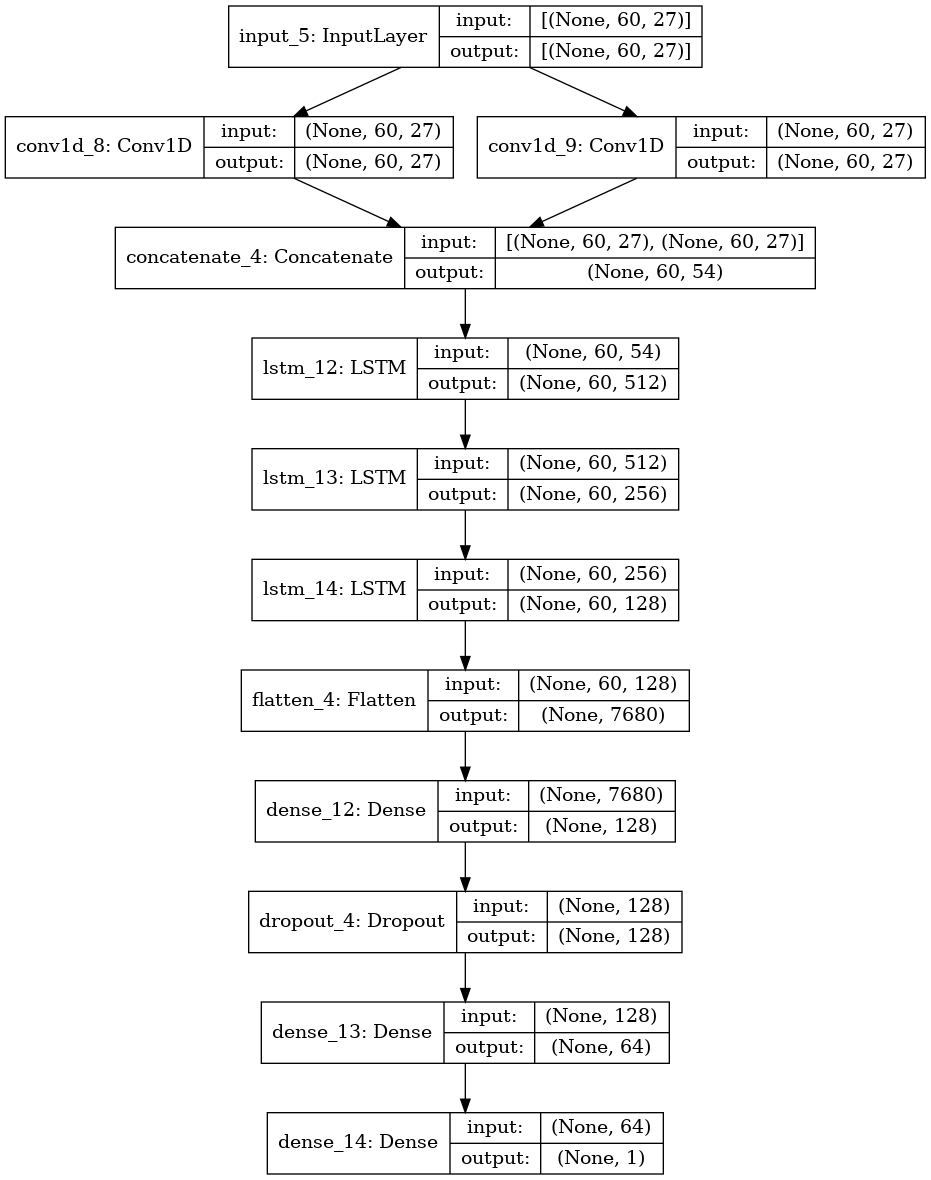

In [14]:
keras.utils.plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
submission["state"] = sum(test_preds)/5
submission.to_csv("submission.csv", index=False)
submission.head()

,sequence,state
0,25968,0.997622
1,25969,0.929546
2,25970,0.007604
3,25971,0.742439
4,25972,0.298742
